In [1]:
"""
@Josh Boquiren
OTIS Lab MUSC
1.21.2023

README: 
- Revised version of "Population - PFC Self-Admin 7.2.ipynb"
- Better version for handling inactive data

POPULATION:
- Acquisition, active and inactive analysis
"""

'\n@Josh Boquiren\nOTIS Lab MUSC\n1.21.2023\n\nREADME: \n- Revised version of "Population - PFC Self-Admin 7.2.ipynb"\n- Better version for handling inactive data\n\nPOPULATION:\n- Acquisition, active and inactive analysis\n'

## Population Analysis

### Preprocessing

In [1]:
#import libraries

#data manipulation
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#directory and file manager
import os

#statistics
import scipy.stats as stats
import scipy.io as sio
from sklearn.metrics import roc_auc_score as auROC
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples


In [46]:
#initialize directories

population = 'ACQUISITION'

basedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data'

earlybasedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data/EarlyAcq'
middlebasedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data/MidAcq'
latebasedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data\LateAcq'

models = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\active-inactive_analysis\universal_models'
results = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\active-inactive_analysis\acquisition\results'

#for later plot titles
plot_titles = ['EARLY', 'MIDDLE', 'LATE']
population_title = "ACQ"

#animals of interest
early_animals_of_interest = [
    'CTL1',
    'ER-L2', 'ER-L1',
    'IG-19',
    'LCDD-PGa1','LCDD-PGa3','LCDD-PGa4','LCDD-PGa5','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  
middle_animals_of_interest = [
    'CTL1',
    'ER-L2', 'ER-L1',
    'IG-19',
    'LCDD-PGa3','LCDD-PGa4','LCDD-PGa5','LCDD-PGa6','LCDD-PGa1',
    'LCDD-PGa-T1','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5','LCDD-PGa-T2',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  
late_animals_of_interest = [
    'CTL1',
    'ER-L2', 'ER-L1',
    'IG-19',
    'LCDD-PGa3', 'LCDD-PGa4','LCDD-PGa5','LCDD-PGa6','LCDD-PGa1',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T5','LCDD-PGa-T4',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  

In [3]:
#frame rate variables
frameaveraging = 4
timebetweenframes = 33.3333
framerate = 30
framerate = timebetweenframes/frameaveraging #raw frame rate
averagedframerate = timebetweenframes/frameaveraging #averaged frame rate

#window size variables
pre_window_size = int(10*framerate) #How many frames per trial before origin to be plotted?
window_size =  int((pre_window_size*2)+(3*framerate)) #How many frames do you want to plot around the origin?
post_window_size = window_size - pre_window_size
baselinefirstframe = 0
baselinelastframe = int(1*framerate)
infusionframe = int(pre_window_size+(3*framerate))

#set cell tracking
tracking = 'No' ### 'Yes' or 'No'
sorting = 'Yes' ### 'Yes' or 'No'
sorttoearly = 'No' ###'Yes' or 'No'; This is for sorting, but align to early data. 'Sorting' must also be Yes
csv_id_for_tracking = 'CUE-DRUG-TMT'

#tracking
if tracking == 'Yes':
    population_active_tracked_early = np.nan*np.ones((1,window_size))
    population_active_tracked_middle = np.nan*np.ones((1,window_size))
    population_active_tracked_late = np.nan*np.ones((1,window_size))
    print ('Cell Tracking')
else:
    print ('No Cell Tracking')

No Cell Tracking


In [4]:
#method for fixing dropped frames
def fix_any_dropped_frames(frame_timestamps):
    first_frame = np.array([0])
    last_frame = np.array([int(np.max(frame_timestamps)+(500*timebetweenframes))])
    frame_index_temp = np.concatenate((first_frame,frame_timestamps, last_frame)) ###adds frame to timepoint '0' and an extra 500 frames at end
    frames_missed = [] ###creates empty list for us to add timestamps for missed frames
    for i in range(len(frame_index_temp)-1): ###iterates through each collected frame
            numframes_missed = int(np.round((frame_index_temp[i+1]-frame_index_temp[i])\
                /timebetweenframes)-1) ### number of missed frames per frame interval
            if numframes_missed > 0: 
                for j in range(numframes_missed):
                    frame_missed = np.array([frame_index_temp[i] + (int(timebetweenframes * (j+1)))])
                    frames_missed = np.concatenate((frames_missed, frame_missed))
    corrected_frame_index = np.array(sorted(np.concatenate((frame_index_temp, frames_missed))))
    return corrected_frame_index

#method for fixing assumed frames
def fix_assumed_frames(frames):
    dropped_frames = []
    diff_frames = np.diff(frames)
    inter_frame_interval = 33
    frame_drop_idx = np.where(diff_frames>1.5*inter_frame_interval)[0]
    for idx in frame_drop_idx:
        numframesdropped = int(np.round((frames[idx+1]-frames[idx])/(inter_frame_interval+0.0))-1)
        temp = [frames[idx]+a*inter_frame_interval for a in range(1,numframesdropped+1)]
        dropped_frames.extend(temp)
    corrected_frames = np.sort(np.concatenate((frames, np.array(dropped_frames))))
    return corrected_frames

#generate behavior data
try:
    assumed_frames = np.load(os.path.join(models, 'assumed_frames.npy'))
    assumed_frame_timestamps = np.load(os.path.join(models, 'assumed_frame_timestamps.npy'))
    print("Loaded behavior data.")
except:
    #load in data
    behaviordata_noframes = sio.loadmat(r"C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data\Spreadsheets\matfile_noframes_3.mat")
    eventlog_noframes = np.squeeze(behaviordata_noframes['eventlog'])

    #parse desired data
    max_of_eventlog_noframes = max(eventlog_noframes[:,1]) #all rows, second column
    length_of_eventlog_noframes = len(eventlog_noframes[:,1])
    x = np.vstack((eventlog_noframes, eventlog_noframes, eventlog_noframes))
    x[length_of_eventlog_noframes:,1]= x[length_of_eventlog_noframes:,1]+max_of_eventlog_noframes
    x[length_of_eventlog_noframes*2:,1]= x[length_of_eventlog_noframes*2:,1]+(2*max_of_eventlog_noframes)
    eventlog_noframes = x

    assumed_frames = fix_any_dropped_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    assumed_frame_timestamps = fix_assumed_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO

    np.save(os.path.join(models, 'assumed_frames'), assumed_frames)
    np.save(os.path.join(models, 'assumed_frames'), assumed_frame_timestamps)
    print("Behavior data processed and loaded.")


Loaded behavior data.


In [5]:
#various methods

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, color=None, label='', linetype='-'):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], linetype, color=color, label=label)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', markersize=3):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)    
    ax.scatter(x, y, color=color, label='%s p=%.3f\nR$^2$=%.3f'% (plot_label, pvalue, R2), s=markersize)
    ax.plot(temp, temppred, color=color)
    return ax, slope, pvalue, R2


def ismembertol(x, y, tol=1E-6):
    # Are elements of x in y within tolerance of tol?
    # x and y must be 1d numpy arrays
    sortx = np.sort(x)
    orderofx = np.argsort(x)
    sorty = np.sort(y)
    current_y_idx = 0
    result = np.nan*np.zeros(x.shape)
    for i, elt in enumerate(sortx):
        temp = sorty[current_y_idx:]
        if np.any(np.abs(temp-elt)<=tol):
            result[orderofx[i]]=1
        else:
            result[orderofx[i]]=0
        temp = np.argwhere(sorty>elt)
        if temp.size>0:
            current_y_idx = temp[0][0]
    return result

def mkdir_p(path):
    #makes a new directory if it doesn't exist
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise 
            
def framenumberforevent(event, frame_timestamps):
    framenumber = np.nan*np.zeros(event.shape)
    for ie, e in enumerate(event):
        if np.isnan(e):
            framenumber[ie] = np.nan
        else:
            temp = np.nonzero(frame_timestamps<=e)[0]
            if temp.shape[0]>0:
                framenumber[ie] = np.nonzero(frame_timestamps<=e)[0][-1]
            else:
                framenumber[ie] = 0
    return framenumber

def calculate_num_licks_for_each_frame(framenumberforlicks, numframes):
    numlicksperframe = np.nan*np.ones((numframes,))
    for i in range(numframes):
        numlicksperframe[i] = np.sum(framenumberforlicks==i)
    return numlicksperframe

def calculate_auROC(x,y,offset_to_zero=True):
    U, p = stats.mannwhitneyu(x,y)
    labels = np.concatenate((np.ones(x.shape), np.zeros(y.shape)))
    data = np.concatenate((x,y))
    A = auROC(labels, data)
    if offset_to_zero:
        return (2*(A-0.5), p)
    else:
        return (A, p)
    
def Benjamini_Hochberg_correction(vector_of_pvals,
                                  alpha = 0.05):
    # This function ipltements the BH FDR correction
    
    # Parameters:
    # Vector of p values from the different tests
    # alpha:significance level
    
    # Returns: Corrected p values. All the p values that are above the FDR threshold are set to 1. 
    #          Remaining p values are unchanged.
    
    sortedpvals = np.sort(vector_of_pvals)
    orderofpvals = np.argsort(vector_of_pvals)
    m = sortedpvals[np.isfinite(sortedpvals)].shape[0] #Total number of hypotheses
    for i in range(m):
        if sortedpvals[i] > (i+1)*alpha/m:
            k = i
            break
        elif i == m-1:
            k = m-1
        
    correctedpvals = np.copy(vector_of_pvals)
    correctedpvals[orderofpvals[k:]] = 1
    correctedpvals[np.isnan(vector_of_pvals)] = np.nan
    return correctedpvals

In [50]:
#method for animal analysis
def analyze_single_session(indir, window_size, pre_window_size):    
    tempfiles = next(os.walk(indir))[2]
    npyfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
        and 'extractedsignals_raw' in f]
    matfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat']

    if len(npyfiles) > 1:
        npyfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
            and 'extractedsignals_raw' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        if npyfile[0][0]!='nan':
            npyfile = npyfile [0]
        matfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' 
            and not 'results' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        matfile = matfile [0]
    else:
        npyfile = npyfiles[0]
        matfile = matfiles[0]
    
    signals = np.squeeze(np.load(os.path.join(indir, npyfile)))
    numneurons = signals.shape[0] 
   
    behaviordata = sio.loadmat(os.path.join(indir, matfile))
    eventlog = np.squeeze(behaviordata['eventlog'])
    licks = np.squeeze(behaviordata['licks'])
    lastframe_timestamp_part1 = np.max(eventlog)
    
    if len(npyfiles) > 1:
        npyfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part2' in f]
        matfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part2' in f and not 'results' in f]
        npyfile2 = npyfiles2[0]
        matfile2 = matfiles2[0]
        signals2 = np.squeeze(np.load(os.path.join(indir, npyfile2))) 
        if signals2[0][0]!='nan':
            signals = np.hstack((signals, signals2))
        behaviordata2 = sio.loadmat(os.path.join(indir, matfile2))
        eventlog2 = np.squeeze(behaviordata2['eventlog'])
        eventlog2[:,1] = eventlog2[:,1]+lastframe_timestamp_part1  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog2))
        lastframe_timestamp_part2 = np.max(eventlog)        
        licks2 = np.squeeze(behaviordata2['licks'])
        licks2 = licks2+lastframe_timestamp_part1
        licks = np.concatenate ([licks, licks2])
    if len(npyfiles) > 2:
        npyfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part3' in f]
        matfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part3' in f and not 'results' in f]
        npyfile3 = npyfiles3[0]
        matfile3 = matfiles3[0]
        signals3 = np.squeeze(np.load(os.path.join(indir, npyfile3))) 
        if signals3[0][0]!='nan':
            signals = np.hstack((signals, signals3))
        behaviordata3 = sio.loadmat(os.path.join(indir, matfile3))
        eventlog3 = np.squeeze(behaviordata3['eventlog'])
        eventlog3[:,1] = eventlog3[:,1]+lastframe_timestamp_part2  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog3))
        lastframe_timestamp_part3 = np.max(eventlog)
        licks3 = np.squeeze(behaviordata3['licks'])
        licks3 = licks3+lastframe_timestamp_part2
        licks = np.concatenate ([licks, licks3])
    if len(npyfiles) > 3:
        npyfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' and 'part4' in f]
        matfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part4' in f and not 'results' in f]
        npyfile4 = npyfiles4[0]
        matfile4 = matfiles4[0]
        signals4 = np.squeeze(np.load(os.path.join(indir, npyfile4))) 
        if signals4[0][0]!='nan':
            signals = np.hstack((signals, signals4))
        behaviordata4 = sio.loadmat(os.path.join(indir, matfile4))
        eventlog4 = np.squeeze(behaviordata4['eventlog'])
        eventlog4[:,1] = eventlog4[:,1]+lastframe_timestamp_part3  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog4))
        lastframe_timestamp_part4 = np.max(eventlog)
        licks4 = np.squeeze(behaviordata4['licks'])
        licks4 = licks4+lastframe_timestamp_part3
        licks = np.concatenate ([licks, licks4])
    #pulling data from eventlog
    activelever = eventlog[eventlog[:,0]==22,1]
    activelevertimeout = eventlog[eventlog[:,0]==222,1]
    inactivelever = eventlog[eventlog[:,0]==21,1]
    inactivelevertimeout = eventlog[eventlog[:,0]==212,1]
    cues = eventlog[eventlog[:,0]==7,1]
    infusions = eventlog[eventlog[:,0]==4,1]    
    signals /= np.mean(signals, axis=1)[:, None]
    signalsT = signals.T
    print("SIGNALST:", signalsT.shape)
    
    ###IF YOUR CODE LACKS FRAME INPUTS, WE CAN ATTEMPT TO PREDICT FRAME TIMING BY USING PREVIOUS FRAME TIMESTAMPS
    if animal == 'CTL1' or animal == 'ER-L1' or animal == 'ER-L2' or animal == 'IG-19' or animal == 'IG-28' or animal == 'PGa-T1' or animal == 'XYZ':
        frame_timestamps = assumed_frame_timestamps ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    else:
        frame_timestamps = fix_any_dropped_frames(eventlog[eventlog[:,0]==9,1])
        
    frame_timestamps = frame_timestamps[::frameaveraging] ###incorporates averaging into timestamp array
    
    ###DISCARDS BEHAVIORAL EVENTS THAT WERE NOT FULLY MONITORED WITH IMAGING
    if signals.shape[1] > frame_timestamps.shape[0]:
        signals = signals[:,:frame_timestamps.shape[0]-1] ###cuts signals so it's not longer than the frame timestamps
    final_frame_timestamp = frame_timestamps[signals.shape[1]] #This is the timestamp of the final frame in milliseconds
    activelever = activelever[activelever<(final_frame_timestamp-(window_size/framerate*1000))]
    activelevertimeout = activelevertimeout[activelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelever = inactivelever[inactivelever<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelevertimeout = inactivelevertimeout[inactivelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    
    seconds_monitored = int(signals.shape[1]/averagedframerate) ###seconds monitored by 2p imaging
    seconds_behavior = int(max(activelever/1000)) ###final seconds to be monitored for behavior

    if seconds_monitored < seconds_behavior: #calculates last fully-monitored active lever press with 2p recording
        included_trials = []
        discarded_trials=[]
        for i in range(len(activelever)):
            if activelever[i]/1000<seconds_monitored:
                included_trials=np.append(included_trials, activelever[i])
            else:
                discarded_trials=np.append(discarded_trials,activelever[i])
        activelever=included_trials 
    
    #combines all presses
    activeleverall = np.hstack((activelever, activelevertimeout))
    inactiveleverall = np.hstack((inactivelever, inactivelevertimeout))
    print('active = ', activeleverall.shape, '    inactive = ',inactiveleverall.shape )
 
    #method for calculating aligned data
    def calculate_aligneddata_forevent(data, frame_after_event):
        framenumberfor_eventofinterest = np.squeeze(framenumberforevent(frame_after_event, frame_timestamps))
        numtrials = framenumberfor_eventofinterest.shape[0]
        
        if data.size==signals.size:
            align = np.NAN*np.zeros([numtrials,window_size,numneurons])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size,numneurons])###CHANGED ON AUGUST 20 2021
        else:
            align = np.NAN*np.zeros([numtrials,window_size])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size])
            
        temp = data
        prevendindex = 0
        for i in range(numtrials):  ###CHANGED THIS SECTION ON AUGUST 20 2021
            tempindex = framenumberfor_eventofinterest[i]
            if np.isfinite(tempindex):
                tempindex = int(tempindex)
                tempstartindex = np.amin([pre_window_size, tempindex]).astype(int)
                startindex = np.amin([tempstartindex, tempindex-prevendindex]).astype(int)
                tempendindex = np.amin([len(frame_timestamps)-tempindex, post_window_size])
                if i<(numtrials-1) and np.isfinite(framenumberfor_eventofinterest[i+1]):
                    endindex = np.amin([framenumberfor_eventofinterest[i+1]-tempindex, tempendindex]).astype(int)
                else:
                    endindex = tempendindex.astype(int)  
                prevendindex = tempindex+endindex
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex,:] = temp[tempindex-startindex:tempindex+endindex,:]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex,:] = temp[tempindex-tempstartindex:tempindex+endindex,:]
                else: 
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex] = temp[tempindex-startindex:tempindex+endindex]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex] = temp[tempindex-tempstartindex:tempindex+endindex]
            else:
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,:,:] = np.nan*np.ones((window_size, numneurons))
                    align[i,:,:] = np.nan*np.ones((window_size, numneurons))
                else:
                    align_to_plot[i,:] = np.nan*np.ones((window_size))
                    align[i,:] = np.nan*np.ones((window_size))

        if temp.shape[0]!=temp.size:         
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0,0]))[0],:,:]     
        else:
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0]))[0],:]
            
        return align, align_to_plot, framenumberfor_eventofinterest

    align_activelever, align_to_plot_activelever, framenumberfor_frameafter_activelever = \
        calculate_aligneddata_forevent(signalsT, activeleverall)  
    populationdata_activelever = np.nanmean(align_activelever, axis=0).T-1
    
    align_inactivelever, align_to_plot_inactivelever, framenumberfor_frameafter_inactivelever = \
        calculate_aligneddata_forevent(signalsT, inactiveleverall)
    populationdata_inactivelever = np.nanmean(align_inactivelever, axis=0).T-1
    
    for i in range(signals.shape[0]):
        if np.isnan(np.mean(signals[i,:])):
            print(animal, fov, 'IMAGE J ROI.ZIP CELL NUMBER %s HAS NaNs AND SHOULD BE CHANGED'%(i+1))
        
    return populationdata_activelever, populationdata_inactivelever, align_activelever, align_inactivelever, framerate

#### Making single session analysis files

In [14]:
#Early population
early_info = []
excluded = []
for animal in early_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
            temp_active = np.nan*np.ones((1, window_size))
            temp_inactive = np.nan*np.ones((1, window_size))
            for fov in sorted(FOVs):
                try:
                    temp1, temp2, temp3, temp4, framerate = analyze_single_session(
                        #analysis parameters
                        os.path.join(earlybasedir, animal, fov), 
                        window_size, 
                        pre_window_size
                        )
                    #saving active and inactive signal data (includig NaN rows)
                    temp_active = np.vstack((temp_active, temp1))
                    temp_inactive = np.vstack((temp_inactive, temp2))
                    #saving aligned active and inactive lever data
                    temp_align_active_lever = temp3
                    temp_align_inactive_lever = temp4
                    early_info.append({'Animal': animal, 'Active': temp1.shape[0], 'Inactive': temp2.shape[0]})
                except Exception as e:
                    print('***ERROR:', e, '***')
                    excluded.append(animal)
            #files for signal data with NaN's
            np.save(os.path.join(earlybasedir, animal, fov, "active"), temp_active[1:,:])
            np.save(os.path.join(earlybasedir, animal, fov, "inactive"), temp_inactive[1:,:])
            #files for aligned lever data
            np.save(os.path.join(earlybasedir, animal, fov, "aligned_active_lever_data"), temp_align_active_lever)
            np.save(os.path.join(earlybasedir, animal, fov, "aligned_inactive_lever_data"), temp_align_inactive_lever)
print('Early excluded animals:', excluded)

#creating dataframe
early_info = pd.DataFrame(early_info)
print('Sum active:', sum(early_info['Active']))
print('Sum inactive:', sum(early_info['Inactive']))

>>> CTL1
active =  (11,)     inactive =  (146,)
>>> ER-L2
active =  (16,)     inactive =  (0,)
>>> ER-L1


C:\Users\jboqu\AppData\Local\Temp\ipykernel_14296\2753076563.py:180: RuntimeWarning: Mean of empty slice
  populationdata_inactivelever = np.nanmean(align_inactivelever, axis=0).T-1


active =  (15,)     inactive =  (0,)
>>> IG-19
active =  (77,)     inactive =  (0,)
>>> LCDD-PGa1
active =  (16,)     inactive =  (0,)
>>> LCDD-PGa3
active =  (17,)     inactive =  (0,)
>>> LCDD-PGa4
active =  (11,)     inactive =  (0,)
>>> LCDD-PGa5
active =  (15,)     inactive =  (0,)
>>> LCDD-PGa6
active =  (22,)     inactive =  (0,)
>>> LCDD-PGa-T1
active =  (6,)     inactive =  (0,)
>>> LCDD-PGa-T2
active =  (31,)     inactive =  (0,)
>>> LCDD-PGa-T3
active =  (20,)     inactive =  (0,)
>>> LCDD-PGa-T4
active =  (22,)     inactive =  (0,)
>>> LCDD-PGa-T5
active =  (15,)     inactive =  (0,)
>>> PGa-T1
active =  (22,)     inactive =  (146,)
>>> PGa-T2
active =  (17,)     inactive =  (81,)
>>> PGa-T3
active =  (14,)     inactive =  (49,)
Early excluded animals: []
Sum active: 2392
Sum inactive: 2392


In [17]:
#printing early_info dataframe
early_info

,Animal,Active,Inactive
0,CTL1,112,112
1,ER-L2,91,91
2,ER-L1,224,224
3,IG-19,85,85
4,LCDD-PGa1,19,19
5,LCDD-PGa3,206,206
6,LCDD-PGa4,105,105
7,LCDD-PGa5,304,304
8,LCDD-PGa6,100,100
9,LCDD-PGa-T1,107,107


In [56]:
#Middle population
middle_info = []
excluded = []
for animal in middle_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
            temp_active = np.nan*np.ones((1, window_size))
            temp_inactive = np.nan*np.ones((1, window_size))
            try:
                for fov in sorted(FOVs):
                    temp1, temp2, temp3, temp4, framerate = analyze_single_session(
                        #analysis parameters
                        os.path.join(middlebasedir, animal, fov), 
                        window_size, 
                        pre_window_size
                        )
                    #saving active and inactive signal data (includig NaN rows)
                    temp_active = np.vstack((temp_active, temp1))
                    temp_inactive = np.vstack((temp_inactive, temp2))
                    #saving aligned active and inactive lever data
                    temp_align_active_lever = temp3
                    temp_align_inactive_lever = temp4
                    middle_info.append({'Animal': animal, 'Active': temp1.shape[0], 'Inactive': temp2.shape[0]})
            except Exception as e:
                    print('***ERROR:', e, '***')
                    excluded.append(animal)
            #files for signal data without NaN's
            np.save(os.path.join(middlebasedir, animal, fov, "active"), temp_active[1:,:])
            np.save(os.path.join(middlebasedir, animal, fov, "inactive"), temp_inactive[1:,:])
            #files for aligned lever data
            np.save(os.path.join(middlebasedir, animal, fov, "aligned_active_lever_data"), temp_align_active_lever)
            np.save(os.path.join(middlebasedir, animal, fov, "aligned_inactive_lever_data"), temp_align_inactive_lever)
print('Middle excluded animals:', excluded)

#creating dataframe
middle_info = pd.DataFrame(middle_info)
print('Sum active:', sum(middle_info['Active']))
print('Sum inactive:', sum(middle_info['Inactive']))

>>> CTL1
SIGNALST: (83749, 158)
active =  (80,)     inactive =  (44,)
>>> ER-L2
SIGNALST: (35524, 99)
active =  (170,)     inactive =  (0,)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_14296\1294720245.py:181: RuntimeWarning: Mean of empty slice
  populationdata_inactivelever = np.nanmean(align_inactivelever, axis=0).T-1


>>> ER-L1
SIGNALST: (70899, 297)
active =  (127,)     inactive =  (1,)
***ERROR: tuple index out of range ***
>>> IG-19
SIGNALST: (12392, 95)
active =  (115,)     inactive =  (7,)
>>> LCDD-PGa3
SIGNALST: (54000, 216)
active =  (16,)     inactive =  (9,)
>>> LCDD-PGa4
SIGNALST: (54000, 94)
active =  (25,)     inactive =  (5,)
>>> LCDD-PGa5
SIGNALST: (49068, 123)
active =  (26,)     inactive =  (18,)
>>> LCDD-PGa6
SIGNALST: (51697, 105)
active =  (26,)     inactive =  (3,)
>>> LCDD-PGa1
SIGNALST: (79142, 29)
active =  (111,)     inactive =  (1,)
***ERROR: tuple index out of range ***
>>> LCDD-PGa-T1
SIGNALST: (9379, 143)
active =  (184,)     inactive =  (0,)
>>> LCDD-PGa-T3
SIGNALST: (30001, 82)
active =  (126,)     inactive =  (0,)
>>> LCDD-PGa-T4
SIGNALST: (15339, 171)
active =  (298,)     inactive =  (0,)
>>> LCDD-PGa-T5
SIGNALST: (46675, 265)
active =  (41,)     inactive =  (0,)
>>> LCDD-PGa-T2
SIGNALST: (33563, 139)
active =  (328,)     inactive =  (1,)
***ERROR: tuple index out of 

In [52]:
#printing middle_info dataframe
middle_info

,Animal,Active,Inactive
0,CTL1,158,158
1,ER-L2,99,99
2,IG-19,95,95
3,LCDD-PGa3,216,216
4,LCDD-PGa4,94,94
5,LCDD-PGa5,123,123
6,LCDD-PGa6,105,105
7,LCDD-PGa-T1,143,143
8,LCDD-PGa-T3,82,82
9,LCDD-PGa-T4,171,171


In [55]:
#Late population
late_info = []
excluded = []
for animal in late_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
            temp_active = np.nan*np.ones((1, window_size))
            temp_inactive = np.nan*np.ones((1, window_size))
            for fov in sorted(FOVs):
                try:
                    temp1, temp2, temp3, temp4, framerate = analyze_single_session(
                        #analysis parameters
                        os.path.join(latebasedir, animal, fov), 
                        window_size, 
                        pre_window_size
                        )
                    #saving active and inactive signal data (includig NaN rows)
                    temp_active = np.vstack((temp_active, temp1))
                    temp_inactive = np.vstack((temp_inactive, temp2))
                    #saving aligned active and inactive lever data
                    temp_align_active_lever = temp3
                    temp_align_inactive_lever = temp4
                    late_info.append({'Animal': animal, 'Active': temp1.shape[0], 'Inactive': temp2.shape[0]})
                except Exception as e:
                    print('***ERROR:', e, '***')
                    excluded.append(animal)
            #files for signal data without NaN's
            np.save(os.path.join(latebasedir, animal, fov, "active"), temp_active[1:,:])
            np.save(os.path.join(latebasedir, animal, fov, "inactive"), temp_inactive[1:,:])
            #files for aligned lever data
            np.save(os.path.join(latebasedir, animal, fov, "aligned_active_lever_data"), temp_align_active_lever)
            np.save(os.path.join(latebasedir, animal, fov, "aligned_inactive_lever_data"), temp_align_inactive_lever)
print('Late excluded animals:', excluded)

#creating dataframe
late_info = pd.DataFrame(late_info)
print('Sum active:', sum(late_info['Active']))
print('Sum inactive:', sum(late_info['Inactive']))

>>> CTL1
SIGNALST: (40000, 102)
active =  (50,)     inactive =  (4,)
>>> ER-L2
SIGNALST: (60000, 87)
active =  (77,)     inactive =  (4,)
>>> ER-L1
SIGNALST: (10495, 237)
active =  (103,)     inactive =  (4,)
>>> IG-19
SIGNALST: (20523, 81)
active =  (136,)     inactive =  (0,)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_14296\1294720245.py:181: RuntimeWarning: Mean of empty slice
  populationdata_inactivelever = np.nanmean(align_inactivelever, axis=0).T-1


>>> LCDD-PGa3
SIGNALST: (54000, 194)
active =  (117,)     inactive =  (6,)
>>> LCDD-PGa4
SIGNALST: (54000, 79)
active =  (29,)     inactive =  (2,)
>>> LCDD-PGa5
SIGNALST: (28031, 201)
active =  (96,)     inactive =  (0,)
>>> LCDD-PGa6
SIGNALST: (16202, 132)
active =  (227,)     inactive =  (2,)
>>> LCDD-PGa1
SIGNALST: (53705, 20)
active =  (96,)     inactive =  (1,)
tuple index out of range
>>> LCDD-PGa-T1
SIGNALST: (57045, 113)
active =  (202,)     inactive =  (0,)
>>> LCDD-PGa-T2
SIGNALST: (15391, 147)
active =  (326,)     inactive =  (0,)
>>> LCDD-PGa-T3
SIGNALST: (54000, 93)
active =  (41,)     inactive =  (0,)
>>> LCDD-PGa-T5
SIGNALST: (54000, 193)
active =  (47,)     inactive =  (0,)
>>> LCDD-PGa-T4
SIGNALST: (52905, 120)
active =  (81,)     inactive =  (1,)
tuple index out of range
>>> PGa-T1
SIGNALST: (40712, 173)
active =  (167,)     inactive =  (5,)
>>> PGa-T2
SIGNALST: (25371, 120)
active =  (129,)     inactive =  (2,)
>>> PGa-T3
SIGNALST: (40975, 145)
active =  (149,)     

In [21]:
#printing middle_info dataframe
late_info

,Animal,Active,Inactive
0,CTL1,102,102
1,ER-L2,87,87
2,ER-L1,237,237
3,IG-19,81,81
4,LCDD-PGa3,194,194
5,LCDD-PGa4,79,79
6,LCDD-PGa5,201,201
7,LCDD-PGa6,132,132
8,LCDD-PGa-T1,113,113
9,LCDD-PGa-T2,147,147


In [63]:
#checking shapes of files

temp_arr = []

for animal in early_animals_of_interest:
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        #load in data
        try:
                active_data = np.load(os.path.join(earlybasedir, animal, fov, "active.npy"))
                inactive = np.load(os.path.join(earlybasedir, animal, fov, "inactive.npy"))
                aligned_active_lever_data = np.load(os.path.join(earlybasedir, animal, fov, "aligned_active_lever_data.npy"))
                aligned_inactive_lever_data = np.load(os.path.join(earlybasedir, animal, fov, "aligned_inactive_lever_data.npy"))
                temp_dict = {
                    'Animal': animal,
                    'Day': 'EARLY',
                    'Active shape': active_data.shape,
                    'Inactive shape': inactive.shape,
                    'Aligned active shape': aligned_active_lever_data.shape,
                    'Aligned inactive shape': aligned_inactive_lever_data.shape
                }
                temp_arr.append(temp_dict)
        except:
               print('***ERROR: no files!***')

for animal in middle_animals_of_interest:
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
        #load in data
        try:
                active_data = np.load(os.path.join(middlebasedir, animal, fov, "active.npy"))
                inactive = np.load(os.path.join(middlebasedir, animal, fov, "inactive.npy"))
                aligned_active_lever_data = np.load(os.path.join(middlebasedir, animal, fov, "aligned_active_lever_data.npy"))
                aligned_inactive_lever_data = np.load(os.path.join(middlebasedir, animal, fov, "aligned_inactive_lever_data.npy"))
                temp_dict = {
                    'Animal': animal,
                    'Day': 'MIDDLE',
                    'Active shape': active_data.shape,
                    'Inactive shape': inactive.shape,
                    'Aligned active shape': aligned_active_lever_data.shape,
                    'Aligned inactive shape': aligned_inactive_lever_data.shape
                }
                temp_arr.append(temp_dict)
        except:
               print('***ERROR: no files!***')

for animal in late_animals_of_interest:
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
        #load in data
        try:
                active_data = np.load(os.path.join(latebasedir, animal, fov, "active.npy"))
                inactive = np.load(os.path.join(latebasedir, animal, fov, "inactive.npy"))
                aligned_active_lever_data = np.load(os.path.join(latebasedir, animal, fov, "aligned_active_lever_data.npy"))
                aligned_inactive_lever_data = np.load(os.path.join(latebasedir, animal, fov, "aligned_inactive_lever_data.npy"))
                temp_dict = {
                    'Animal': animal,
                    'Day': 'LATE',
                    'Active shape': active_data.shape,
                    'Inactive shape': inactive.shape,
                    'Aligned active shape': aligned_active_lever_data.shape,
                    'Aligned inactive shape': aligned_inactive_lever_data.shape
                }
                temp_arr.append(temp_dict)
        except:
               print('***ERROR: no files!***')

animal_df = pd.DataFrame(temp_arr)
animal_df

,Animal,Day,Active shape,Inactive shape,Aligned active shape,Aligned inactive shape
0,CTL1,EARLY,"(112, 190)","(112, 190)","(11, 190, 112)","(146, 190, 112)"
1,ER-L2,EARLY,"(91, 190)","(91, 190)","(16, 190, 91)","(0, 190, 91)"
2,ER-L1,EARLY,"(224, 190)","(224, 190)","(15, 190, 224)","(0, 190, 224)"
3,IG-19,EARLY,"(85, 190)","(85, 190)","(77, 190, 85)","(0, 190, 85)"
4,LCDD-PGa1,EARLY,"(19, 190)","(19, 190)","(16, 190, 19)","(0, 190, 19)"
5,LCDD-PGa3,EARLY,"(206, 190)","(206, 190)","(17, 190, 206)","(0, 190, 206)"
6,LCDD-PGa4,EARLY,"(105, 190)","(105, 190)","(11, 190, 105)","(0, 190, 105)"
7,LCDD-PGa5,EARLY,"(304, 190)","(304, 190)","(15, 190, 304)","(0, 190, 304)"
8,LCDD-PGa6,EARLY,"(100, 190)","(100, 190)","(22, 190, 100)","(0, 190, 100)"
9,LCDD-PGa-T1,EARLY,"(107, 190)","(107, 190)","(6, 190, 107)","(0, 190, 107)"


### Plotting data

#### Stacking data

In [39]:
#method for stacking data

def stack_data(indir, animals_of_interest, window, signals_file, aligned_levers_file):
    temp_data = np.nan*np.ones((1, window))
    for animal in animals_of_interest:
            FOVs = next(os.walk(os.path.join(indir, animal)))[1]
            for fov in sorted(FOVs):
                    try:
                        #load in data
                        signal_data = np.load(os.path.join(indir, animal, fov, signals_file))
                        lever_data = np.load(os.path.join(indir, animal, fov, aligned_levers_file))
                        #stack data
                        temp_data = np.vstack((temp_data, signal_data))
                    except:
                        print('***ERROR: no files!***')
    data = temp_data[1:,:]
    return(data, lever_data)

In [23]:
#stacking early data

#early active data
early_active, early_active_levers = stack_data(earlybasedir, early_animals_of_interest, window_size, "active.npy", 'aligned_active_lever_data.npy')

#num neurons
numneurons_early_active = early_active.shape[0]

#calculating population data - baseline
baseline = np.mean(early_active[:,baselinefirstframe:baselinelastframe], axis=1)
early_active = early_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(early_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_early_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
early_active_mean = np.nanmean(early_active, axis=0)


#early inactive data
early_inactive, early_inactive_levers = stack_data(earlybasedir, early_animals_of_interest, window_size, "inactive.npy", 'aligned_inactive_lever_data.npy')

#num neurons
numneurons_early_inactive = early_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(early_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
early_inactive = early_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(early_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_early_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
early_inactive_mean = np.nanmean(early_inactive, axis=0)

print('Active shape:', early_active.shape)
print('Active lever shape:', early_active_levers.shape)
print('Inative shape:', early_inactive.shape)
print('Inctive lever shape:', early_inactive_levers.shape)

Active shape: (2392, 190)
Active lever shape: (14, 190, 117)
Inative shape: (2392, 190)
Inctive lever shape: (49, 190, 117)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_14296\2070251981.py:32: RuntimeWarning: Mean of empty slice
  tempresponse = np.nanmean(early_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)


In [40]:
#stacking middle data

#middle active data
middle_active, middle_active_levers = stack_data(middlebasedir, middle_animals_of_interest, window_size, "active.npy", 'aligned_active_lever_data.npy')

#num neurons is length of data
numneurons_middle_active = middle_active.shape[0]

#calculating population data - baseline
baseline = np.mean(middle_active[:,baselinefirstframe:baselinelastframe], axis=1)
middle_active = middle_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(middle_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_middle_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
middle_active_mean = np.nanmean(middle_active, axis=0)


#middle inactive data
middle_inactive, middle_inactive_levers = stack_data(middlebasedir, middle_animals_of_interest, window_size, "inactive.npy", 'aligned_inactive_lever_data.npy')

#num neurons is length of data
numneurons_middle_inactive = middle_inactive.shape[0]-1 

#calculating population data - baseline
baseline = np.mean(middle_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
middle_inactive = middle_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(middle_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_middle_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
middle_inactive_mean = np.nanmean(middle_inactive, axis=0)

print('Active shape:', middle_active.shape)
print('Active lever shape:', middle_active_levers.shape)
print('Inative shape:', middle_inactive.shape)
print('Inctive lever shape:', middle_inactive_levers.shape)

Active shape: (2127, 190)
Active lever shape: (170, 190, 171)
Inative shape: (2127, 190)
Inctive lever shape: (373, 190, 171)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_14296\3190049211.py:32: RuntimeWarning: Mean of empty slice
  tempresponse = np.nanmean(middle_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)


In [25]:
#stacking late data

#late active data
late_active, late_active_levers = stack_data(latebasedir, late_animals_of_interest, window_size, "active.npy", 'aligned_active_lever_data.npy')

#num neurons is length of data
numneurons_late_active = late_active.shape[0]-1 

#calculating population data - baseline
baseline = np.mean(late_active[:,baselinefirstframe:baselinelastframe], axis=1)
late_active = late_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(late_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_late_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
late_active_mean = np.nanmean(late_active, axis=0)


#late inactive data
late_inactive, late_inactive_levers = stack_data(latebasedir, late_animals_of_interest, window_size, "inactive.npy", 'aligned_inactive_lever_data.npy')

#num neurons is length of data
numneurons_late_inactive = late_inactive.shape[0]-1 

#calculating population data - baseline
baseline = np.mean(late_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
late_inactive = late_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(late_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_late_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
late_inactive_mean = np.nanmean(late_inactive, axis=0)

print('Active shape:', late_active.shape)
print('Active lever shape:', late_active_levers.shape)
print('Inative shape:', late_inactive.shape)
print('Inctive lever shape:', late_inactive_levers.shape)

Active shape: (1952, 190)
Active lever shape: (129, 190, 120)
Inative shape: (1952, 190)
Inctive lever shape: (2, 190, 120)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_14296\3815450266.py:32: RuntimeWarning: Mean of empty slice
  tempresponse = np.nanmean(late_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)


#### Plots

In [26]:
#method for filtering NaN from processed active/inactive data

def filter_NAN(processed_data, windowsize, prewindowsize, framerate):
        filtered_stack = np.nan*np.ones((1, windowsize))
        for row in processed_data:
                if np.isfinite(row[0]):
                        filtered_stack = np.vstack((filtered_stack, row))
        filtered_stack = filtered_stack[1:,:]
        response = np.nanmean(filtered_stack[:,prewindowsize-(1*int(framerate)):prewindowsize+1*int(framerate)], axis=1)
        sortresponse = np.argsort(response)[::-1]
        return(filtered_stack, sortresponse)

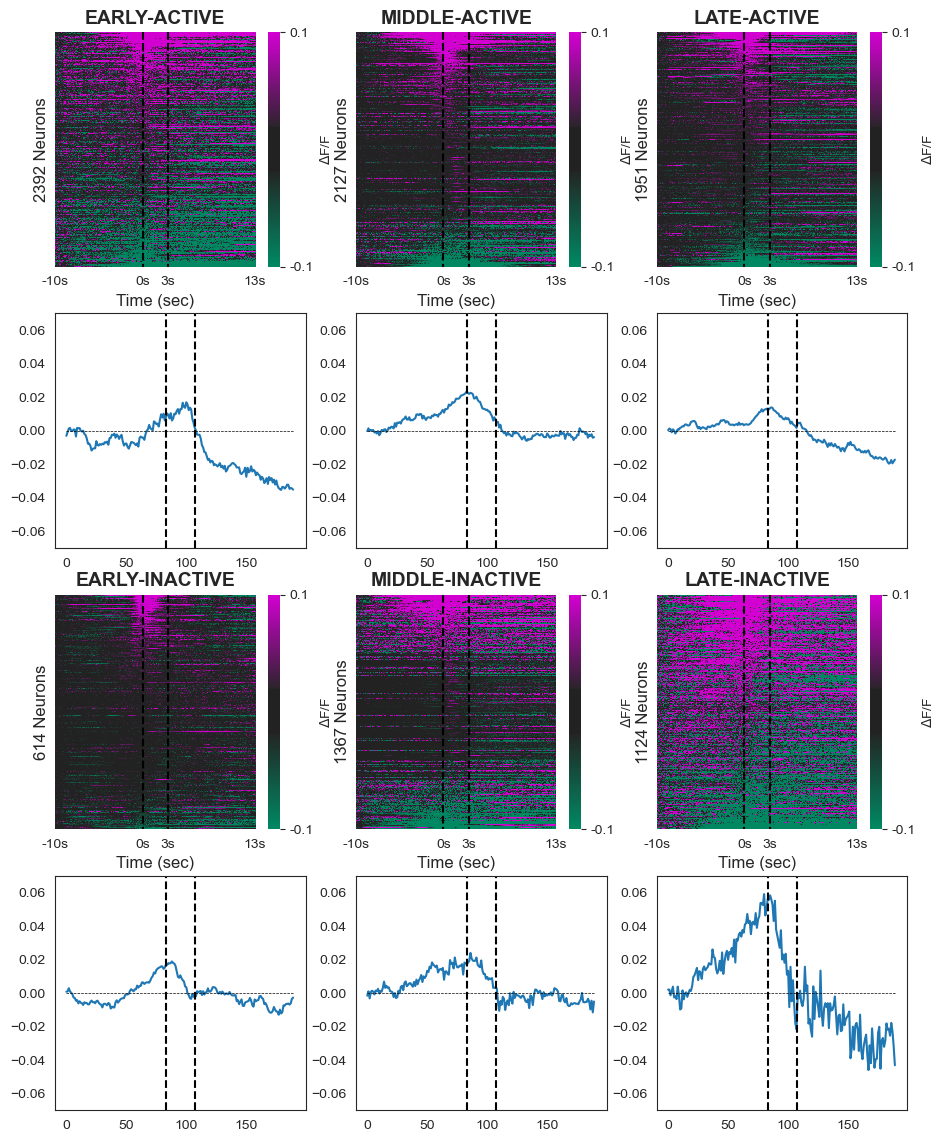

In [27]:
#plot and dataframe of used animals

# initialize the plot
# 2 rows and 3 columns of graphs; may end up with blank column
fig, axs = plt.subplots(4, 3, figsize=(11, 14))
sns.set_style('white')

# setting max/min variables
cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax

# early active plots
ax = axs[0, 0]

# heatmap
hm = sns.heatmap(early_active[sortresponse_early_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_early_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_early_active], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numneurons_early_active], '--k', linewidth=1.5)

# line plot
ax = axs[1, 0]
ax.plot(early_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.axvline(infusionframe, color='black', linestyle='--')

# early inactive plots (sorted to active plot)
ax = axs[2, 0]

#filtering NaN's
sorted_early_inactive, inactive_sort = filter_NAN(early_inactive, window_size, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_early_inactive[inactive_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % sorted_early_inactive.shape[0], fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_early_inactive], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numneurons_early_inactive], '--k', linewidth=1.5)

# line plot
ax = axs[3, 0]
ax.plot(early_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.axvline(infusionframe, color='black', linestyle='--')

# middle active plots
ax = axs[0, 1]

# heatmap
hm = sns.heatmap(middle_active[sortresponse_middle_active, :], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_middle_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_middle_active], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numneurons_middle_active], '--k', linewidth=1.5)

# line plot
ax = axs[1, 1]
ax.plot(middle_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.axvline(infusionframe, color='black', linestyle='--')

# middle inactive plots
ax = axs[2, 1]

#filtering NaN's
sorted_middle_inactive, inactive_sort = filter_NAN(middle_inactive, window_size, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_middle_inactive[inactive_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % sorted_middle_inactive.shape[0], fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_middle_inactive], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numneurons_middle_inactive], '--k', linewidth=1.5)

# line plot
ax = axs[3, 1]
ax.plot(middle_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.axvline(infusionframe, color='black', linestyle='--')

# late active plots
ax = axs[0, 2]

# heatmap
hm = sns.heatmap(late_active[sortresponse_late_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_late_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_late_active], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numneurons_late_active], '--k', linewidth=1.5)

# line plot
ax = axs[1, 2]
ax.plot(late_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.axvline(infusionframe, color='black', linestyle='--')

# late inactive plots
ax = axs[2, 2]

#filtering NaN's
sorted_late_inactive, inactive_sort = filter_NAN(late_inactive, window_size, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_late_inactive[inactive_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % sorted_late_inactive.shape[0], fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_late_inactive], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numneurons_late_inactive], '--k', linewidth=1.5)

# line plot
ax = axs[3, 2]
ax.plot(late_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.axvline(infusionframe, color='black', linestyle='--')


In [70]:
#save fig
fig.savefig(os.path.join(basedir, 'PFC_HEROIN_SA_Acquisition(active-inactive)_population_heatmaps.PDF'), format='PDF')
fig.savefig(os.path.join(basedir, 'PFC_HEROIN_SA_Acquisition(active-inactive)_population_heatmaps.PNG'), format='PNG')

Early CTL1 FOV1
active =  (11,)     inactive =  (146,)
Early ER-L2 FOV1
active =  (16,)     inactive =  (0,)
Early ER-L1 FOV1
active =  (15,)     inactive =  (0,)
Early IG-19 FOV2


C:\Users\jboqu\AppData\Local\Temp\ipykernel_14296\2753076563.py:180: RuntimeWarning: Mean of empty slice
  populationdata_inactivelever = np.nanmean(align_inactivelever, axis=0).T-1


active =  (77,)     inactive =  (0,)
Early LCDD-PGa1 FOV1
active =  (16,)     inactive =  (0,)
Early LCDD-PGa3 FOV1
active =  (17,)     inactive =  (0,)
Early LCDD-PGa4 FOV1
active =  (11,)     inactive =  (0,)
Early LCDD-PGa5 FOV1
active =  (15,)     inactive =  (0,)
Early LCDD-PGa6 FOV1
active =  (22,)     inactive =  (0,)
Early LCDD-PGa-T1 FOV1
active =  (6,)     inactive =  (0,)
Early LCDD-PGa-T2 FOV1
active =  (31,)     inactive =  (0,)
Early LCDD-PGa-T3 FOV1
active =  (20,)     inactive =  (0,)
Early LCDD-PGa-T4 FOV1
active =  (22,)     inactive =  (0,)
Early LCDD-PGa-T5 FOV1
active =  (15,)     inactive =  (0,)
Early PGa-T1 FOV1
active =  (22,)     inactive =  (146,)
Early PGa-T2 FOV1
active =  (17,)     inactive =  (81,)
Early PGa-T3 FOV1
active =  (14,)     inactive =  (49,)
Middle CTL1 FOV1
active =  (80,)     inactive =  (44,)
Middle ER-L2 FOV2
active =  (170,)     inactive =  (0,)
Middle ER-L1 FOV1
active =  (127,)     inactive =  (1,)


IndexError: tuple index out of range

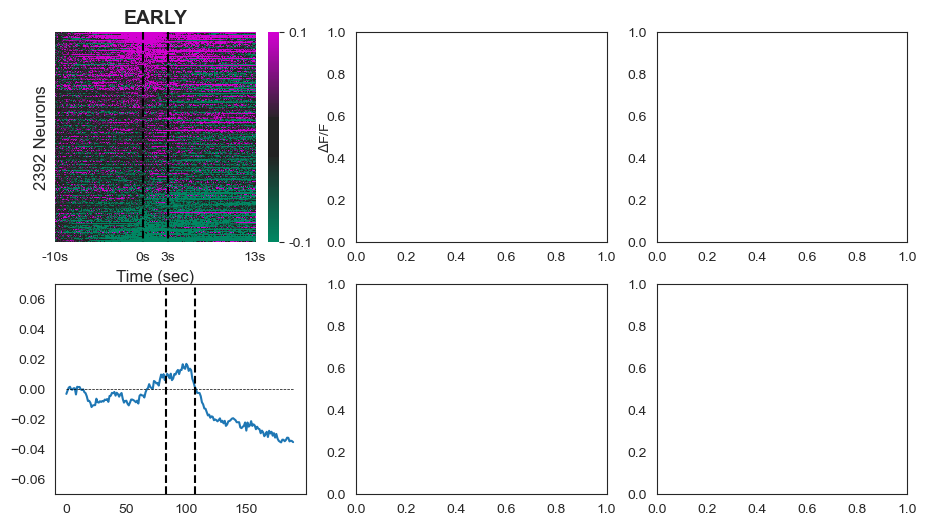

In [47]:
"""
This cell looks for an existing .npy file for the active population data, and if one does not exsist, it processes
the data and creates a file. After checking/creating active population data, it plots the data. This process reiterates
for 2 or 3 populations.
"""

#initialize the plot
fig, axs = plt.subplots(2, 3, figsize=(11, 6)) #2 rows and 3 columns of graphs; may end up with blank column
sns.set_style('white')

cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax


#FIRST POPULATION
populationdata_active_population = np.nan*np.ones((1, window_size)) # The second _population refers to population across all animals and FOVs
populationdata_inactive_population = np.nan*np.ones((1, window_size))
for animal in early_animals_of_interest:
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        print('Early', animal, fov)
        temp1, temp2, temp3, temp4, framerate = analyze_single_session(
            #analysis parameters
            os.path.join(earlybasedir, animal, fov), 
            window_size, 
            pre_window_size
            )
        populationdata_active_population = np.vstack((populationdata_active_population, temp1))
        populationdata_inactive_population = np.vstack((populationdata_inactive_population, temp2))

        if tracking == 'Yes' and 'tracked' in fov:
            tempfiles = next(os.walk(os.path.join(earlybasedir, animal, fov)))[2]  
            roi_csvfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.csv' \
                        and csv_id_for_tracking in f][0]
            roi_early_list, roi_middle_list, roi_late_list = np.loadtxt(os.path.join(earlybasedir,\
                        animal, fov, roi_csvfile), delimiter = ',', unpack=True)
            active_population_temp = np.nan*np.ones((len(roi_early_list), window_size))
            for i in range(len(roi_early_list)):
                active_population_temp[i,:] = temp1[(int(roi_early_list[i]-1)),:]
            population_active_tracked_early = np.vstack((population_active_tracked_early, active_population_temp))

numneurons = populationdata_active_population.shape[0]-1 
populationdata_active_population = populationdata_active_population[1:,:]
populationdata_inactive_population = populationdata_inactive_population[1:,:]

if tracking == 'Yes':
    population_active_tracked_early = population_active_tracked_early[1:,:]
    populationdata_active_population = population_active_tracked_early
    
baseline = np.mean(populationdata_active_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_active = populationdata_active_population - baseline[:,None]
baseline = np.mean(populationdata_inactive_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_inactive = populationdata_inactive_population - baseline[:,None]
numrois_early = pop_active.shape[0]
tempresponse = np.mean(pop_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_early = np.argsort(tempresponse)[::-1]

early_active = pop_active
early_inactive = pop_inactive

#first population graphs
ax = axs[0,0]
if sorting == 'Yes':
    hm = sns.heatmap(early_active[sortresponse_early,:], ax=ax, vmax = cmax, vmin = cmin, linewidth=0, 
        cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
        cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False) #sets tick label increments
else:
    hm = sns.heatmap(early_active, ax=ax, vmax = cmax, vmin = cmin, linewidth=0, 
        cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
        cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False)

cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1,.1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

ax.grid(False)
ax.set_title(plot_titles[0], fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' %numneurons, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numrois_early], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numrois_early], '--k', linewidth=1.5) 

ax = axs[1,0]
ax.plot(np.mean(early_active, axis = 0))
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0,0], '--k', linewidth=0.5) 
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.axvline(infusionframe, color='black', linestyle='--')


#SECOND POPULATION
populationdata_active_population = np.nan*np.ones((1, window_size)) # The second _population refers to population across all animals and FOVs
populationdata_inactive_population = np.nan*np.ones((1, window_size))
for animal in middle_animals_of_interest:
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
        print('Middle', animal, fov)
        temp1, temp2, temp3, temp4, framerate = analyze_single_session(
            #analysis parameters
            os.path.join(middlebasedir, animal, fov),
            window_size,
            pre_window_size
            )

        populationdata_active_population = np.vstack((populationdata_active_population, temp1))
        populationdata_inactive_population = np.vstack((populationdata_inactive_population, temp2))

        if tracking == 'Yes' and 'tracked' in fov:
            tempfiles = next(os.walk(os.path.join(middlebasedir, animal, fov)))[2]  
            roi_csvfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.csv' \
                        and csv_id_for_tracking in f][0]
            roi_early_list, roi_middle_list, roi_late_list = np.loadtxt(os.path.join(middlebasedir,\
                        animal, fov, roi_csvfile), delimiter = ',', unpack=True)
            active_population_temp = np.nan*np.ones((len(roi_middle_list), window_size))
            
            for i in range(len(roi_middle_list)):
                active_population_temp[i,:] = temp1[(int(roi_middle_list[i]-1)),:]
            population_active_tracked_middle = np.vstack((population_active_tracked_middle, active_population_temp))

numneurons=populationdata_active_population.shape[0]-1 
populationdata_active_population = populationdata_active_population[1:,:]
populationdata_inactive_population = populationdata_inactive_population[1:,:]

if tracking == 'Yes':
    population_active_tracked_middle = population_active_tracked_middle[1:,:]
    populationdata_active_population = population_active_tracked_middle

baseline = np.mean(populationdata_active_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_active = populationdata_active_population - baseline[:,None]
baseline = np.mean(populationdata_inactive_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_inactive = populationdata_inactive_population - baseline[:,None]
numrois_middle = pop_active.shape[0]
tempresponse = np.mean(pop_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_middle = np.argsort(tempresponse)[::-1]

middle_active = pop_active

#second population graphs
ax = axs[0,1]
if sorting == 'Yes' and sorttoearly =='No':
    hm = sns.heatmap(middle_active[sortresponse_middle,:], ax=ax, vmax = cmax, vmin = cmin, linewidth=0, 
        cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
        cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)
elif sorting == 'Yes' and sorttoearly =='Yes':
    hm = sns.heatmap(middle_active[sortresponse_early,:], ax=ax, vmax = cmax, vmin = cmin, linewidth=0, 
        cmap=sns.diverging_palette140(154, 308,n=230,s=100,sep=50,center='dark'))
else:
    hm = sns.heatmap(middle_active, ax=ax, vmax = cmax, vmin = cmin, linewidth=0, 
        cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
        cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)

cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1,.1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

ax.grid(False)
ax.set_title(plot_titles[1], fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' %numneurons, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numrois_middle], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numrois_middle], '--k', linewidth=1.5) 

ax = axs[1,1]
ax.plot(np.mean(middle_active, axis = 0))
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0,0], '--k', linewidth=0.5) 
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.axvline(infusionframe, color='black', linestyle='--')


#THIRD POPULATION
populationdata_active_population = np.nan*np.ones((1, window_size)) # The second _population refers to population across all animals and FOVs
populationdata_inactive_population = np.nan*np.ones((1, window_size))
for animal in late_animals_of_interest:
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
        print('Late', animal, fov)
        temp1, temp2, temp3, temp4, framerate = analyze_single_session(
            #analysis parameters
            os.path.join(latebasedir, animal, fov),
            window_size,
            pre_window_size)
        
        populationdata_active_population = np.vstack((populationdata_active_population, temp1))
        populationdata_inactive_population = np.vstack((populationdata_inactive_population, temp2))

        if tracking == 'Yes' and 'tracked' in fov:
            tempfiles = next(os.walk(os.path.join(latebasedir, animal, fov)))[2]  
            roi_csvfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.csv' \
                        and csv_id_for_tracking in f][0]
            roi_early_list, roi_middle_list, roi_late_list = np.loadtxt(os.path.join(latebasedir,\
                        animal, fov, roi_csvfile), delimiter = ',', unpack=True)
            active_population_temp = np.nan*np.ones((len(roi_late_list), window_size))
            for i in range(len(roi_late_list)):
                active_population_temp[i,:] = temp1[(int(roi_late_list[i]-1)),:]
            population_active_tracked_late = np.vstack((population_active_tracked_late, active_population_temp))
        
numneurons=populationdata_active_population.shape[0]-1
populationdata_active_population = populationdata_active_population[1:,:]
populationdata_inactive_population = populationdata_inactive_population[1:,:]

if tracking == 'Yes':
    population_active_tracked_late = population_active_tracked_late[1:,:]
    populationdata_active_population = population_active_tracked_late

baseline = np.mean(populationdata_active_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_active = populationdata_active_population - baseline[:,None]
baseline = np.mean(populationdata_inactive_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_inactive = populationdata_inactive_population - baseline[:,None]
numrois_late = pop_active.shape[0]
tempresponse = np.mean(pop_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_late = np.argsort(tempresponse)[::-1]

late_active = pop_active

#third population graphs
if len(plot_titles)==3:
        ax = axs[0,2]
        if sorting == 'Yes' and sorttoearly =='No':
                hm = sns.heatmap(late_active[sortresponse_late,:], ax=ax, vmax = cmax, vmin = cmin, linewidth=0, 
                cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False, yticklabels=False)
        elif sorting == 'Yes' and sorttoearly =='Yes':
                hm = sns.heatmap(late_active[sortresponse_early,:], ax=ax, vmax = cmax, vmin = cmin, linewidth=0, 
                cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False, yticklabels=False)
        else:
                hm = sns.heatmap(late_active, ax=ax, vmax = cmax, vmin = cmin, linewidth=0, 
                cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'), #sep=50 creates a little more black space for greater distinction
                cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False, yticklabels=False)

        cbar = hm.collections[0].colorbar
        cbar.set_ticks([-.1,.1])
        cbar.set_ticklabels([cmin, cmax])
        ax.set(xticks=[0, pre_window_size, infusionframe, window_size-1])
        ax.set(xticklabels=["-10s", "0s", "3s", "13s"])

        ax.grid(False)
        ax.set_title(plot_titles[2], fontweight="bold", fontsize=14)
        ax.set_ylabel('%s Neurons' %numneurons, fontsize=12)
        ax.set_xlabel('Time (sec)', fontsize=12)
        ax.plot([pre_window_size, pre_window_size],
                [0, numrois_late], '--k', linewidth=1.5)
        ax.plot([infusionframe, infusionframe],
                [0, numrois_late], '--k', linewidth=1.5) 

        ax = axs[1,2]
        ax.plot(np.mean(late_active, axis = 0))
        ax.set_ylim([-.07, .07])
        ax.plot([0, window_size],
                [0,0], '--k', linewidth=0.5) 
        ax.axvline(pre_window_size, color='black', linestyle='--')
        ax.axvline(infusionframe, color='black', linestyle='--')

fig.tight_layout

## Cluster Analysis

### Creating cluster models

In [13]:
#import libraries

import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
from scipy import interpolate
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)

import matplotlib.pyplot as plt

In [14]:
#combine data across sets
new_active = np.vstack((early_active, middle_active, late_active)) 
print('New active data shape:', new_active.shape)


New active data shape: (6471, 190)


In [15]:
#select data that you want to analyze 
populationdata = new_active

print (populationdata.shape, 'array for clustering')

numneurons = populationdata.shape[0]
populationdata_nan_excluded = np.nan*np.ones((1, window_size))

for i in range(numneurons):
    if np.mean(populationdata[i,:]) < 1000:
        populationdata_nan_excluded = np.vstack((populationdata_nan_excluded,populationdata[i]))
populationdata_nan_excluded = populationdata_nan_excluded[1:,:]

print('Original population data shape:', populationdata.shape, '\nNew population data shape:', populationdata_nan_excluded.shape)
    
sortwindow = [pre_window_size, infusionframe] #sort responses between CS+ onset and reward
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1] #corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.1 # Maximum colormap value. 

trial_types = ['Active-Inactive'] #FIXME - add inactive?
    
populationdata = populationdata[:,(pre_window_size - int(3*framerate)):(pre_window_size + int(6*framerate))]

(6471, 190) array for clustering
Original population data shape: (6471, 190) 
New population data shape: (6471, 190)


In [16]:
#plot parameters

plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.labelspacing'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['lines.scale_dashes'] = False
plt.rcParams['lines.dashed_pattern'] = (2, 1)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.color'] = 'k'
sns.set_style('ticks')

C:\Users\jboqu\AppData\Local\Temp\ipykernel_13692\510226586.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


(6471, 73)


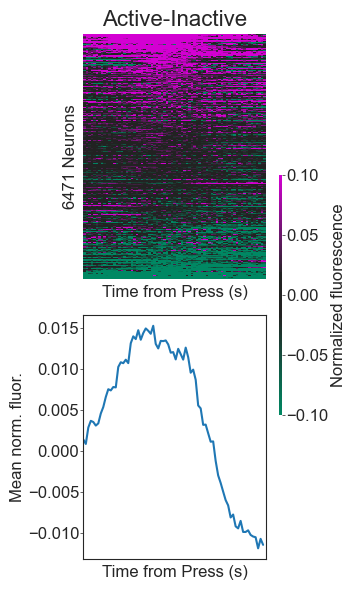

In [17]:
#plotting combined data

fig, axs = plt.subplots(2,len(trial_types),figsize=(3.3,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

for t in range(len(trial_types)):
    axs[t].set_title(trial_types[t])
    ax = axs[0]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                vmin=-cmax,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'Normalized fluorescence'},
                yticklabels=False)
    ax.grid(False)
    ax.tick_params(width=0.5)   

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(infusionframe, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from Press (s)')
    
        
    ax = axs[1]
    sns.lineplot(data=np.mean(populationdata[sortresponse, t*window_size:(t+1)*window_size], axis=0), dashes=False,
               ax=ax)
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(infusionframe, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from Press (s)')
    ax.set_xticks([])
    
axs[0].set_ylabel('%s Neurons' %numneurons)
axs[1].set_ylabel('Mean norm. fluor.')


fig.tight_layout()
fig.subplots_adjust(right=0.82)

print(populationdata.shape)


Number of PCs = 73
[64.91338611 10.2312414   4.45240287  1.58091315  0.80633826  0.66672167
  0.5825006   0.44136103  0.43379301  0.40555411  0.37864709  0.37120224
  0.36475367  0.34947565  0.34517268  0.33631552  0.33020215  0.32450128
  0.32017795  0.31567741  0.30915355  0.30589675  0.30382759  0.30061485
  0.29640789  0.29007313  0.28614768  0.28243187  0.28089501  0.27781772
  0.27424562  0.26900712  0.26791766  0.2603469   0.25947987  0.25652493
  0.25332502  0.25158008  0.25014076  0.24688984  0.24260699  0.23823083
  0.23746757  0.23643824  0.23251974  0.22892889  0.22728022  0.22437107
  0.22379855  0.21748446  0.21553767  0.21148112  0.20981545  0.20465658
  0.20167531  0.19862798  0.19738994  0.19366453  0.19206765  0.1911085
  0.18554648  0.18344391  0.18068545  0.17789126  0.17656601  0.17437587
  0.16756014  0.16719039  0.16353765  0.15944741  0.15677655  0.15518393
  0.15358195]
Number of PCs to keep = 3


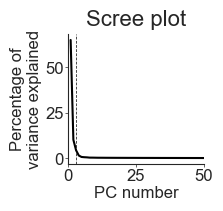

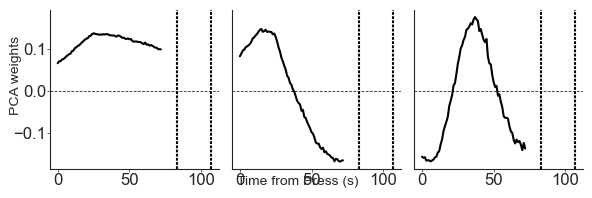

In [18]:
load_savedpca_or_dopca = 'dopca' #select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(models, 'PCA_ACQ.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(models, 'PCA_ACQ.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)
np.save(os.path.join(models, 'PCA_ACQ_transformed-data.npy'), transformed_data)
transformed_data = np.load(os.path.join(models, 'PCA_ACQ_transformed-data.npy'))

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
print(x)
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by siplty bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
ax.set_xlim([0,50])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key['Active-Inactive'] = (0,0,0) 
# colors_for_key['Inactive'] = (0.5,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey], label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
    ax.axvline(pre_window_size+int(framerate*3), linestyle='--', color='k', linewidth=1.5)
    ax.axhline(0, linestyle='--', color='k', linewidth=0.5)
    #ax.annotate(s='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction', #FIXME
    #            textcoords='axes fraction', multialignment='center', size='large')
#     if pc >= num_retained_pcs-numcols:
#         ax.set_xticks([0, pre_window_size,
#                        infusionframe, window_size])
#         ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
#                              for a in [0, pre_window_size,
#                                        infusionframe, window_size]])
#     else:
#         ax.set_xticks([])
#         ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from Press (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)

# fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - CueDrugTMT PCs.PDF'), format='PDF')
# fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - CueDrugTMT PCs.png'), format='PNG')


In [19]:
#clustering

max_n_clusters = 10 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([197, 394, 591, 788, 985, 1182, 1379, 1576, 1773, 1970]) # This should be selected for each dataset
# appropriately. When 1511 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data. [500, 1000, 1500,  2500, 3000, 3500, 4000, 4500, 5000, 5500]
      
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters, nn, silhouette_scores[n_clustersidx, nnidx]))

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(models, 'silhouette_scores_ACQ.pickle'), 'wb') as f:
    pickle.dump(temp, f)   
    

Done with numclusters = 2, num nearest neighbors = 197: score = 0.427


KeyboardInterrupt: 

In [ ]:
with open(os.path.join(models, 'silhouette_scores_ACQ.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = np.load(os.path.join(models, 'PCA_ACQ_transformed-data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print ('Num clusters:', n_clusters)
print('Num nearest neighbors:', n_nearest_neighbors)

#redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=n_nearest_neighbors)

#different forms of clustering
# model = KMeans(n_clusters=n_clusters, algorithm = 'elkan')
# model = AgglomerativeClustering(n_clusters=n_clusters)

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

#save this optimal clustering model.
with open(os.path.join(models, 'PFC_SA_clusteringmodel.pickle'), 'wb') as f:
    pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels

#saving new labels
newlabels = reorder_clusters(model.labels_)

#create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

colors_for_cluster = [[0.933, 0.250, 0.211],[0.941, 0.352, 0.156],[0.964, 0.572, 0.117],[0.980, 0.686, 0.250],[0.545, 0.772, 0.247],[0.215, 0.701, 0.290],[0, 0.576, 0.270],[0, 0.650, 0.611],[0.145, 0.662, 0.878]]

np.save(os.path.join(models, 'clusterlabels_ACQ.npy'), newlabels)
##ONLY USE IF YOU WANT TO OVERWRITE EXISTING, SAVED CLUSTERING DATA

In [ ]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this exaplte all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each saplte
    saplte_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine') #FIXME: saptle???

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for sapltes belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            saplte_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 sapltes

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    #fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - CueDrugTMT Silhouettes.PDF'), format='PDF')
    #fig.savefig(os.path.join(basedir, 'Results', 'PFC HEROIN SA - CueDrugTMT Silhouettes.PNG'), format='PNG')

In [ ]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

In [15]:
####This section saves cluster IDs to each FOV Folder for future use. 
####DO NOT RUN/SAVE UNLESS YOU WANT TO OVERWRITE CLUSTER LISTS

cluster_id_list = newlabels
print('cluster id list shape:', cluster_id_list.shape)

cellcounter = 0

##Assign cluster IDs to neurons within early animals of interest
for animal in early_animals_of_interest:
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        aligned_active_lever_data = np.load(os.path.join(earlybasedir, animal, fov, "aligned_active_lever_data.npy"))
        numneurons = aligned_active_lever_data.shape[2]
        neuron_id_list = []
        for neuron in np.arange(numneurons):
            neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
        cellcounter = numneurons + cellcounter
        #np.save(os.path.join(models, 'cluster_list_per_fov_EARLY_ACQ.npy'), neuron_id_list)
firstcellearly = 0
lastcellearly = cellcounter
#np.save(os.path.join(models, 'cluster_list_per_session_EARLY_ACQ.npy'), newlabels[firstcellearly:lastcellearly])
print('EARLY:', newlabels[firstcellearly:lastcellearly].shape)

##Assign cluster IDs to neurons within middle animals of interest
for animal in middle_animals_of_interest:
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
        aligned_active_lever_data = np.load(os.path.join(middlebasedir, animal, fov, "aligned_active_lever_data.npy"))
        numneurons = aligned_active_lever_data.shape[2]
        neuron_id_list = []
        for neuron in np.arange(numneurons):
            neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
        cellcounter = numneurons + cellcounter
        #np.save(os.path.join(models,'cluster_list_per_fov_MIDDLE_ACQ.npy'), neuron_id_list)
firstcellmiddle = 0
lastcellmiddle = cellcounter
#np.save(os.path.join(models, 'cluster_list_per_session_MIDDLE_ACQ.npy'), newlabels[firstcellearly:lastcellearly])
print('MIDDLE:', newlabels[firstcellearly:lastcellearly].shape)
       
###Assign cluster IDs to neurons within late animals of interest
for animal in late_animals_of_interest:
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
        aligned_active_lever_data = np.load(os.path.join(latebasedir, animal, fov, "aligned_active_lever_data.npy"))
        numneurons = aligned_active_lever_data.shape[2]
        neuron_id_list = []
        for neuron in np.arange(numneurons):
            neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
        cellcounter = numneurons + cellcounter
        #np.save(os.path.join(models, 'cluster_list_per_fov_LATE_ACQ.npy'), neuron_id_list)
firstcelllate = 0
lastcelllate = cellcounter
#np.save(os.path.join(models, 'cluster_list_per_session_LATE_ACQ.npy'), newlabels[firstcellearly:lastcellearly])
print('LATE:', newlabels[firstcellearly:lastcellearly].shape)


NameError: name 'newlabels' is not defined

### Plotting clusters

In [30]:
#initializing data
early_populationdata = early_active
middle_populationdata = middle_active
late_populationdata = late_active
all_populationdata = np.vstack((early_active, middle_active, late_active))

#num neurons
early_numneurons = early_populationdata.shape[0]
middle_numneurons = middle_populationdata.shape[0]
late_numneurons = late_populationdata.shape[0]
all_numneurons = all_populationdata.shape[0]

print('Early population num neurons:', early_numneurons)
print('Middle population num neurons:', middle_numneurons)
print('Late population num neurons:', late_numneurons)
print('All population num neurons:', all_numneurons)
print()

#cluster list files
early_newlabels = np.load(os.path.join(earlybasedir, 'cluster_list_per_session_Acquisition.npy')) #put clustering files in a folder to loop through
middle_newlabels = np.load(os.path.join(middlebasedir, 'cluster_list_per_session_Acquisition.npy'))
late_newlabels = np.load(os.path.join(latebasedir, 'cluster_list_per_session_Acquisition.npy'))

#limiting indexing to only values in original file up to the amount of neurons used
early_newlabels = early_newlabels[:early_numneurons] 
middle_newlabels = middle_newlabels[:middle_numneurons]
late_newlabels = late_newlabels[:late_numneurons]
all_newlabels = np.hstack((early_newlabels, middle_newlabels, late_newlabels))

#the label values should match the num of neurons
print('Early labels shape:', early_newlabels.shape)
print('Middle labels shape:', middle_newlabels.shape)
print('Late labels shape:', late_newlabels.shape)
print('All labels shape:', all_newlabels.shape)



Early population num neurons: 2392
Middle population num neurons: 2127
Late population num neurons: 1952
All population num neurons: 6471

Early labels shape: (2392,)
Middle labels shape: (2127,)
Late labels shape: (1952,)
All labels shape: (6471,)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_14296\2562199919.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


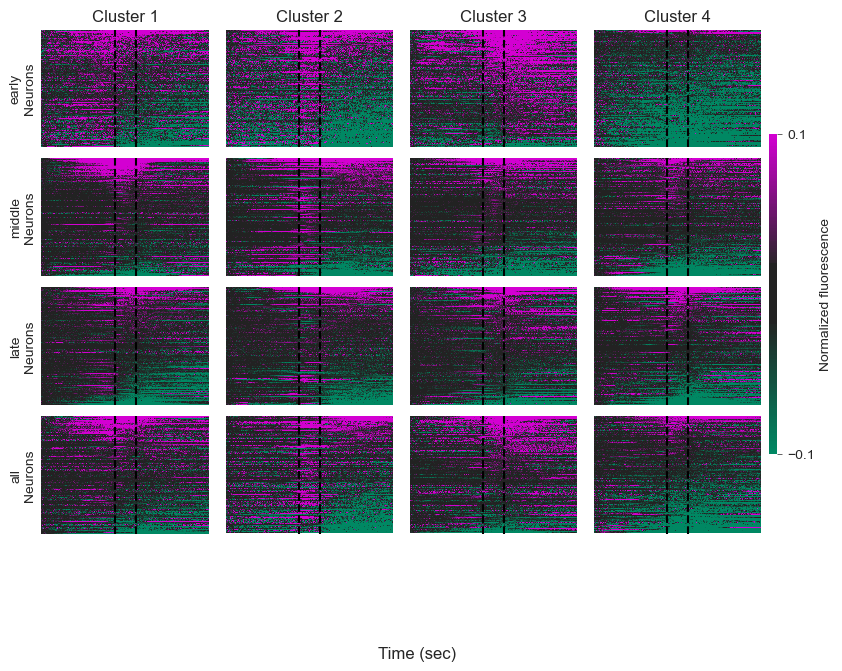

In [31]:
sessions = ['early', 'middle', 'late', 'all'] ###SET TO THE DIFFERENT TIME POINTS THAT WERE USED FOR TRACKING
numclusters = 4 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)

sortwindow = {}
for c, cluster in enumerate(uniquelabels):
    sortwindow[c] = {}
    if c == 0:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 1:
        sortwindow[c] = [infusionframe+int(1*framerate), -1]
    if c == 2:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 3:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    
cmax = 0.1

fig, axs = plt.subplots(len(sessions),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(sessions)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            temp = early_populationdata[np.where(early_newlabels==cluster)[0],:] #this threw indexing error
        elif session == 'middle':
            temp = middle_populationdata[np.where(middle_newlabels==cluster)[0],:]
        elif session == 'late':
            temp = late_populationdata[np.where(late_newlabels==cluster)[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
        numneuronsincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[c][0]:sortwindow[c][1]], axis=1))[::-1]
        hm = sns.heatmap(
                    temp[sortresponse],
                    ax=axs[s, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_xticklabels([])
        axs[s, cluster].set_yticks([])
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axvline(infusionframe, linestyle='--', color='k', linewidth=1.5)
        if cluster==0:
            axs[s, 0].set_ylabel('%s\nNeurons'%(session))
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))

fig.text(0.5, 0.05, 'Time (sec)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)



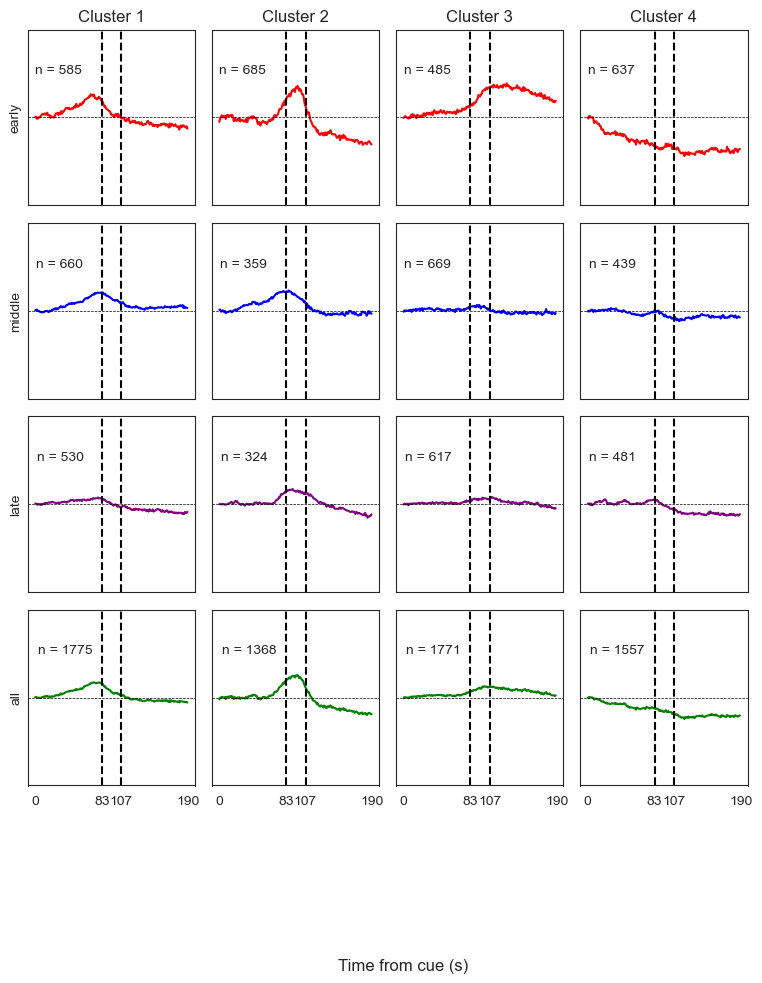

In [32]:
fig, axs = plt.subplots(len(sessions), len(uniquelabels),
                        figsize=(2*len(uniquelabels),3*len(sessions)))

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

colors_for_key = ['red','blue','purple','green']

for c, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            temp = early_populationdata[np.where(early_newlabels==cluster)[0],:]
        elif session == 'middle':
            temp = middle_populationdata[np.where(middle_newlabels==cluster)[0],:]
        elif session == 'late':
            temp = late_populationdata[np.where(late_newlabels==cluster)[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
        numneuronsincluster[c] = temp.shape[0]
        temp = np.mean(temp, axis = 0)        
        sns.lineplot(data = temp, dashes = False, color = colors_for_key[s],
                    ax=axs[s, c])

        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_yticks([])
        axs[s, cluster].set(ylim=(-.2, .2))
        axs[s, cluster].text(x = s, y = .1, s = 'n = %d'%(numneuronsincluster[c]))
        
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axvline(infusionframe, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[s, 0].set_ylabel(session)
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)


## Multivoxel Pattern Analysis *(decoding)*

In [ ]:
#import libraries

import subprocess
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, SVR
from statsmodels.distributions.empirical_distribution import ECDF

In [ ]:
#various methods

def binaryclassifier(y, X):
    hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
    clf = GridSearchCV(SVC(), hyperparameters, cv=10)
    if np.any(np.isnan(X)):
        accuracy=np.nan
        print ('nan detected in single neuron! within ', fov)
    else:
        clf.fit(X, y)
        accuracy = clf.best_score_
    return accuracy

def svmregression(y, X):
    hyperparameters = {'kernel': ['rbf'], 'C': np.logspace(-3, 3, 5),
                      'epsilon': np.logspace(-3, 3, 5),
                      'gamma': np.logspace(-5, 5, 10)}
    clf = GridSearchCV(SVR(), hyperparameters, cv=10)
    if np.all(np.isnan(X)):
        R2=np.nan
    else:
        clf.fit(X, y)
        """y_pred = clf.predict(X)
        plt.plot(y,y_pred,'ko')"""
        R2 = clf.best_score_
    #reference for 10-fold cross-validation http://web.cs.iastate.edu/~jtian/cs573/Papers/Kohavi-IJCAI-95.pdf
    return R2

In [ ]:
###DECODING. Note: this takes time (e.g., ~45 minutes for 3500 neurons). Be sure your parameters below (~line 73) are what you want

groups = ['Early','Middle', 'Late'] ###INSERT YOUR GROUPS (E.G., EARLY AND LATE LEARNING)
session_analysis_split_by_ensemble = ['Yes'] ###SET TO ['Yes'] OR TO ['No']
decoding = ['Neuron', 'Trial'] ###SET TO Neuron or Session and Trial or Lick
numclusters = 3 ###SET TO NUMBER OF CLUSTERS

# late_animals_of_interest = ['PNAC-JO1']

baseline = [1, 8]  ###These variables are for assigning neuronal data epochs
leverresponse = [pre_window_size-9, pre_window_size-1]

numshuffles = 1 
classification_accuracy = {}
uniquelabels = np.arange(numclusters)
numneuronsincluster = np.nan*np.ones((numclusters,))

datadir=0
for group in groups:
    classification_accuracy[group] = {}
    classification_accuracy[group]['individualneurons'] = {}
    classification_accuracy[group]['individualneurons']['shuffled'] = {}
    classification_accuracy[group]['individualneurons']['unshuffled'] = {}
    classification_accuracy[group]['session'] = {}
    classification_accuracy[group]['session']['shuffled'] = {}
    classification_accuracy[group]['session']['unshuffled'] = {}
    
    if group == 'CueRein':
        animals_of_interest = early_animals_of_interest   
    if group == 'CueRein':
        animals_of_interest = middle_animals_of_interest
        if session_analysis_split_by_ensemble == ['Yes']:
            for c, cluster in enumerate(uniquelabels):
                classification_accuracy[group]['session']['shuffled'][c] = {}
                classification_accuracy[group]['session']['unshuffled'][c] = {}

    numneuronstillnow = 0
    for animal in animals_of_interest:
        fovs = next(os.walk(os.path.join(basedir, group, animal)))[1]
        for fov in sorted(fovs):
            if session_analysis_split_by_ensemble == ['Yes'] and group == 'CueRein':
                cluster_id_list_fov = np.load(os.path.join(basedir, group, animal, fov, fov+'cluster_list_per_fov.npy'))
            temp1, temp2, activetrials, temp4, framerate = analyze_single_session(os.path.join(basedir, group, animal, fov),
                                                            window_size, pre_window_size)
            
            ###THIS SECTION DELETES ANY TRIALS WITH NANs
            for i in reversed(range(activetrials.shape[0])): ###reversed to prevent deletion from messing up indexing
                if np.isnan(np.mean(activetrials[i,:,:])):
                    activetrials = np.delete(activetrials, i, axis = 0)

            ###THIS SECTION ALIGNS DATA FOR DECODING        
            numtrials = activetrials.shape[0]
            numsapltes = activetrials.shape[1]
            numneuronsinfov = activetrials.shape[2]

            baseline_active = np.nan*np.ones((numtrials,numneuronsinfov))
            response_active = np.nan*np.ones((numtrials,numneuronsinfov))

            activeflag = np.hstack((np.zeros((numtrials)), np.ones((numtrials))))
            
            for neuron in range(numneuronsinfov):
                baseline_active[:,neuron] = np.nanmean(activetrials[:,baseline[0]:baseline[1],neuron], axis=1)
                response_active[:,neuron] = np.nanmean(activetrials[:,leverresponse[0]:leverresponse[1],neuron], axis=1)
                
                ###CHANGE THESE VARIABLES TO ADJUST WHAT YOU ARE DECODING AND ENSURE IT ALIGNS WITH YOUR FLAGS
                neuralactivity_trialtype = np.vstack((baseline_active, response_active)) ###FOR COMPARING TRIAL TYPES
                
               ###TRIAL DECODING IN SINGLE NEURONS
                if session_analysis_split_by_ensemble == ['No'] and decoding == ['Neuron','Trial']:
                    classification_accuracy[group]['individualneurons']['unshuffled'][numneuronstillnow+neuron] = \
                        binaryclassifier(activeflag, np.expand_dims(neuralactivity_trialtype[:,neuron], axis=1))

                    shuffledresults = np.nan*np.ones((numshuffles,))
                    for shuffleid in range(numshuffles):
                        shuffled_flag = np.random.permutation(activeflag)
                        shuffledresults[shuffleid] = binaryclassifier(shuffled_flag,\
                                np.expand_dims(neuralactivity_trialtype[:,neuron], axis=1))
                    classification_accuracy[group]['individualneurons']['shuffled'][numneuronstillnow+neuron] = \
                        shuffledresults
            
            ###TRIAL DECODING BY SESSION
            if session_analysis_split_by_ensemble == ['No'] and decoding == ['Session','Trial']:
                    classification_accuracy[group]['session']['unshuffled'][fov] = \
                        binaryclassifier(activeflag,neuralactivity_trialtype)                                                                           
                    shuffledresults = np.nan*np.ones((numshuffles,))
                    for shuffleid in range(numshuffles):
                        shuffled_flag = np.random.permutation(activeflag)
                        shuffledresults[shuffleid] = binaryclassifier(shuffled_flag, neuralactivity_trialtype)
                    classification_accuracy[group]['session']['shuffled'][fov] = shuffledresults

            
            ###TRIAL DECODING BY SESSION & ENSEMBLE
            if session_analysis_split_by_ensemble == ['Yes'] and group == 'LateAcq' and decoding == ['Session', 'Trial']:
                for c, cluster in enumerate(uniquelabels):
                    if np.count_nonzero(cluster_id_list_fov==c) > 1:
                        temp = np.squeeze(neuralactivity_trialtype[:, np.where(cluster_id_list_fov==cluster)])
                        classification_accuracy[group]['session']['unshuffled'][c][fov] = \
                            binaryclassifier(activeflag,temp)                                                             
                        shuffledresults = np.nan*np.ones((numshuffles,))
                        for shuffleid in range(numshuffles):
                            shuffled_flag = np.random.permutation(activeflag)
                            shuffledresults[shuffleid] = binaryclassifier(shuffled_flag, temp)
                        classification_accuracy[group]['session']['shuffled'][c][fov] = shuffledresults

            numneuronstillnow += numneurons
